In [1]:
from rsna_retro.imports import *

Loading imports


In [2]:
from rsna_retro.metadata import *

In [3]:
from rsna_retro.preprocess import *

In [4]:
from rsna_retro.train import *

In [5]:
torch.cuda.set_device(5)

In [6]:
df_any = Meta.df_any
df_any.head()

,Modality,PatientID,StudyInstanceUID,SeriesInstanceUID,StudyID,ImagePositionPatient,ImageOrientationPatient,SamplesPerPixel,PhotometricInterpretation,Rows,...,MultiWindowCenter,WindowCenter1,MultiWindowWidth,WindowWidth1,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
SOPInstanceUID,,,,,,,,,,,,,,,,,,,,,
ID_2a8702d25,CT,ID_ff137633,ID_d17053848c,ID_7098f7c836,,-126.437378,1.0,1,MONOCHROME2,512,...,NaN,NaN,NaN,NaN,1,0,1,1,0,0
ID_66891ac22,CT,ID_42940b2c,ID_17e33f43d0,ID_e14dd0090b,,-125.000000,1.0,1,MONOCHROME2,512,...,NaN,NaN,NaN,NaN,1,0,1,0,0,0
ID_8e6e5b51f,CT,ID_76fbed32,ID_1d8eaa14ef,ID_e3919709a0,,-125.000000,1.0,1,MONOCHROME2,512,...,NaN,NaN,NaN,NaN,1,0,0,0,0,1
ID_cb8b9b514,CT,ID_20039b63,ID_1cfe3e70dd,ID_e3b5d8d9b8,,-125.000000,1.0,1,MONOCHROME2,512,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0
ID_ee683911f,CT,ID_a065f3ac,ID_9c727ac231,ID_99e83a310d,,-125.000000,1.0,1,MONOCHROME2,512,...,1.0,40.0,1.0,80.0,0,0,0,0,0,0


In [7]:
fns = L(list(df_any.index))

In [8]:
def get_data(fns, bs, sz, img_dir='nocrop_jpg', splits=Meta.splits_any):
    if sz <= 256: img_dir = f'{img_dir}256'
    return get_data_gen(fns, bs=bs, img_tfm=get_pil_fn(path/img_dir), 
                        sz=sz, splits=splits)

## Load Model

In [10]:
name = 'baseline_any'

In [11]:
dbch = get_data(fns, 512, 128)
learn = get_learner(dbch, xresnet34)

In [12]:
learn.model

Sequential(
  (0): Sequential(
    (0): ConvLayer(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): ConvLayer(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): ConvLayer(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): ResBlock(
        (convs): Sequential(
          (0): ConvLayer(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): Batch

## Training

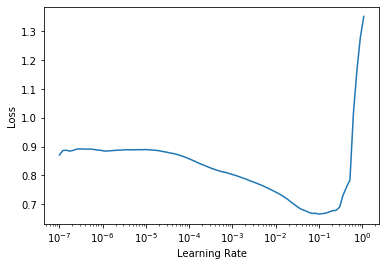

In [13]:
learn.lr_find()

In [14]:
do_fit(learn, 20, 4e-2)
learn.save(f'runs/{name}-1')

epoch,train_loss,valid_loss,accuracy_multi,accuracy_any,time
0,0.266240,0.287296,0.896027,0.798358,03:08
1,0.241071,0.455157,0.834358,0.642220,03:09
2,0.220794,0.245314,0.909208,0.846669,03:09
3,0.210261,0.232049,0.915097,0.841743,03:10
4,0.201050,0.331564,0.893705,0.773805,03:10
5,0.194363,0.212419,0.923745,0.862296,03:09
6,0.190274,0.200284,0.928363,0.868494,03:11
7,0.187776,0.209559,0.926124,0.862032,03:11
8,0.181433,0.230091,0.917719,0.850377,03:11
9,0.179590,0.524540,0.778956,0.530817,03:10


In [22]:
learn.dbunch = get_data(fns, 512, 256)
learn.load(f'runs/{name}-1')

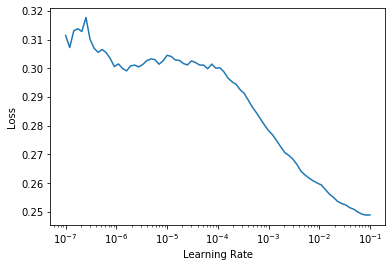

In [23]:
learn.lr_find()

In [ ]:
do_fit(learn, 20, 1e-2)
learn.save(f'runs/{name}-2')

epoch,train_loss,valid_loss,accuracy_multi,accuracy_any,time
0,0.168597,0.181131,0.936101,0.888386,07:53
1,0.157852,0.173359,0.938688,0.890425,07:58
2,0.158901,0.179443,0.935792,0.885605,07:56


In [ ]:
fns_full = L(list(df_comb.index))
learn.dbunch = get_data(fns_full, 512, 256, splits=splits)
do_fit(learn, 2, 5e-4)
learn.save(f'runs/{name}-3-full')

## Submission

In [11]:
learn.load(f'runs/{name}-3-full')
sub_fn = f'subm/{name}'

In [12]:
learn.dbunch = get_test_data(meta.df_tst, bs=512, sz=None, tst_dir='tst_jpg256')

In [13]:
ob = learn.dbunch.one_batch()

In [16]:
preds,targs = learn.get_preds()

In [ ]:
pred_csv = submission(meta.df_tst, preds, fn=sub_fn)

In [20]:
from IPython.display import FileLink, FileLinks
from kaggle import api

In [21]:
FileLink(f'{sub_fn}.csv')

/home/ashaw/kaggle/rsna_retro/subm/baseline_any.csv

In [22]:
api.competition_submit(f'{sub_fn}.csv', 'train_02_any', 'rsna-intracranial-hemorrhage-detection')

100%|██████████| 26.0M/26.0M [00:04<00:00, 6.23MB/s]


Successfully submitted to RSNA Intracranial Hemorrhage Detection

In [27]:
api.competitions_submissions_list('rsna-intracranial-hemorrhage-detection')[0]

{'ref': 13722309,
 'totalBytes': 27277209,
 'date': '2019-12-10T08:50:51.717Z',
 'description': 'train_02_any',
 'errorDescription': None,
 'fileName': 'baseline_any.csv',
 'publicScore': '0.72453',
 'privateScore': '0.07846',
 'status': 'complete',
 'submittedBy': 'Andrew Shaw',
 'submittedByRef': 'bearpelican',
 'teamName': 'Andrew Shaw',
 'type': 'standard',
 'url': 'https://www.kaggle.com/submissions/13722309/13722309.raw'}

## Export

In [3]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 01_data_01_metadata_stage2.ipynb.
Converted 01_data_02_preprocess_windows.ipynb.
Converted 02_train_01_train.ipynb.
Converted 04_orig_replace_ashaw_refactor.ipynb.
Converted 04_replace_ashaw_refactor.ipynb.
Converted 04b_orig_replace_ashaw_refactor.ipynb.
Converted 10_qure.ipynb.
Converted 12_merge.ipynb.
Converted 14_xgboost.ipynb.
Converted 16_slice_e2e-shallow.ipynb.
Converted 16b_orig_slice_e2e-shallow.ipynb.
This cell doesn't have an export destination and was ignored:
e
Converted 17_slice_model-deep.ipynb.
Converted 21_cleanup-nocrop2.ipynb.
Converted 26_submit_final.ipynb.
Converted 27_ensemble_tabular_nn.ipynb.
Converted 99_index.ipynb.
Converted cleanup-combine-qure.ipynb.
Converted delete_03b_cleanup-tif.ipynb.
Converted submit.ipynb.
Converted walkthru.ipynb.
Converted x00_tcia-ct-segm-prep.ipynb.
Converted x00_tcia-ct-segm-train.ipynb.
